In [1]:
import os
import re
import tempfile
import warnings

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
import tqdm
from hyperopt import STATUS_OK, SparkTrials, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from lightgbm import LGBMClassifier
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import ColSpec, Schema
from pyspark.sql import SparkSession
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE, RFECV
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from JapanHorseRaceAnalytics.utilities.base import (
    get_base_dir,
    get_spark_session,
    read_hive_table,
)
from JapanHorseRaceAnalytics.utilities.metrics import (
    calculate_binary_classifier_statistics,
)
from JapanHorseRaceAnalytics.utilities.mlflow import get_colspecs
from JapanHorseRaceAnalytics.utilities.structured_logger import logger

# Set pandas display options
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)

# Set seed for reproducibility
os.environ["PYTHONHASHSEED"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)
random_state = 42


shap.initjs()
japanize_matplotlib.japanize()

In [2]:
spark = get_spark_session()

24/03/07 07:00:52 WARN Utils: Your hostname, Hanks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.40.105 instead (on interface en0)
24/03/07 07:00:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/03/07 07:00:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
data = read_hive_table(
    table_name="features_20240304_v1",
    schema="jhra_curated",
    spark_session=spark,
    use_cache=True,
    parse_dates=["meta_発走日時"],
)

logger.info(f"Original data shape: {data.shape}")

# drop from data where cat_トラック種別 == "障害"
data = data[(data["cat_トラック種別"] != "障害")]

# drop from data where meta_int_race_horses_異常区分 != '0'
data = data[(data["meta_int_race_horses_異常区分"] == "0")]

# keep only horses that have 3 races
data = data[
    (data["num_1走前着順"].notnull())
    & (data["num_2走前着順"].notnull())
    & (data["num_3走前着順"].notnull())
]

# Impute num_入厩何日前
data["num_入厩何日前"].fillna(0, inplace=True)

logger.info(f"Data shape after filtering: {data.shape}")

data.reset_index(drop=True, inplace=True)
data.head()

{"event": "Read from parquet /Users/hankehly/Projects/JapanHorseRaceAnalytics/data/sql_tables/features_20240304_v1.snappy.parquet to pandas", "level": "info", "timestamp": "2024-03-06T22:00:53.601712Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Original data shape: (1108166, 23)", "level": "info", "timestamp": "2024-03-06T22:00:53.795665Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}
{"event": "Data shape after filtering: (752305, 23)", "level": "info", "timestamp": "2024-03-06T22:00:54.059212Z", "logger": "JapanHorseRaceAnalytics.utilities.base"}


,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,meta_int_race_horses_異常区分,meta_実績複勝オッズ,cat_トラック種別,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_入厩何日前逆数,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
0,01011102,01,5.0,2001-08-04 10:15:00+09:00,51.0,False,0,False,0,0,2.9,ダート,7.0,8.0,2.0,0.250000,0.0,1.0,0.174604,False,False,True,False
1,01011102,05,4.0,2001-08-04 10:15:00+09:00,77.0,False,0,False,0,0,1.1,ダート,4.0,3.0,4.0,0.333333,0.0,1.0,0.077879,False,False,False,False
2,01011107,07,5.0,2001-08-04 13:15:00+09:00,75.0,False,0,False,0,0,2.0,ダート,1.0,2.0,3.0,1.000000,0.0,1.0,0.004530,False,False,False,False
3,01011110,01,9.0,2001-08-04 14:55:00+09:00,0.0,False,0,False,0,0,10.4,芝,10.0,6.0,1.0,0.333333,0.0,1.0,0.207357,False,False,True,False
4,01011111,13,8.0,2001-08-04 15:30:00+09:00,0.0,False,0,False,0,0,10.2,ダート,7.0,8.0,1.0,0.333333,0.0,1.0,0.134168,False,False,True,False


In [4]:
data.columns

Index(['meta_レースキー', 'meta_馬番', 'meta_着順', 'meta_発走日時', 'meta_本賞金',
       'meta_単勝的中', 'meta_単勝払戻金', 'meta_複勝的中', 'meta_複勝払戻金',
       'meta_int_race_horses_異常区分', 'meta_実績複勝オッズ', 'cat_トラック種別', 'num_1走前着順',
       'num_2走前着順', 'num_3走前着順', 'num_複勝率', 'num_入厩何日前', 'num_入厩何日前逆数',
       'num_過去3走重み付き着順成績', 'cat_堅実な馬', 'cat_訳あり凡走', 'cat_過去3走中2走好走',
       'cat_過去3走繋がりあり'],
      dtype='object')

In [19]:
num_cols = [
    "num_1走前着順",
    "num_2走前着順",
    "num_3走前着順",
    "num_複勝率",
    "num_入厩何日前",
    # "num_入厩何日前逆数", # Handling NULL?
    "num_過去3走重み付き着順成績",
]

cat_cols = [
    "cat_トラック種別",
    "cat_堅実な馬",
    "cat_訳あり凡走",
    "cat_過去3走中2走好走",
    "cat_過去3走繋がりあり",
]

train_cols = num_cols + cat_cols
meta_cols = ["meta_レースキー", "meta_複勝的中", "meta_複勝払戻金"]
all_cols = num_cols + cat_cols + meta_cols

preprocessor = ColumnTransformer(
    transformers=[
        # fmt: off
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
        # fmt: on
    ],
    remainder="drop",
)

pipeline = ImblearnPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=random_state)),
        ("classifier", LGBMClassifier(random_state=random_state)),
    ]
)

X = data
y = data["meta_複勝的中"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (601844, 23)
X_test: (150461, 23)
y_train: (601844,)
y_test: (150461,)


In [13]:
import seaborn as sns
import tempfile
import mlflow
import re
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import warnings


def create_objective_fn(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    df_payout: pd.DataFrame,
    experiment_name: str,
):
    """
    df_payout should have the same index as *_test and have the following columns:
    * レースキー
    * 馬番
    * 発走日時
    * payout - amount won if betting 100 yen.
    """

    def train(params):
        mlflow.set_experiment(experiment_name=experiment_name)
        with mlflow.start_run():
            mlflow.log_params(params)

            preprocessor = ColumnTransformer(
                transformers=[
                    # fmt: off
                    ("num", StandardScaler(), num_cols),
                    ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
                    # fmt: on
                ],
                remainder="drop",
            )

            model = ImblearnPipeline(
                steps=[
                    ("preprocessor", preprocessor),
                    ("smote", SMOTE(random_state=random_state)),
                    ("classifier", LGBMClassifier(**params)),
                ]
            )

            model.fit(X_train, y_train)
            mlflow.sklearn.log_model(sk_model=model, artifact_path="model")

            y_pred_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            metrics = {
                "loss": log_loss(y_test, y_pred_proba),
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "roc_auc": roc_auc_score(y_test, y_pred),
            }
            mlflow.log_metrics(metrics)

            # Calculate payout rates by group
            results = pd.concat(
                [
                    df_payout,
                    pd.DataFrame(
                        np.c_[y_test, y_pred_proba],
                        columns=["actual", "proba_true"],
                    ),
                ],
                axis=1,
            )
            payout_all = calculate_binary_classifier_statistics(
                results, group_by=None, payout_column_name="payout"
            )
            payout_month = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month,
                payout_column_name="payout",
            )
            payout_season = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.month % 12 // 3,
                payout_column_name="payout",
            )
            payout_year = calculate_binary_classifier_statistics(
                results,
                group_by=results["発走日時"].dt.year,
                payout_column_name="payout",
            )
            payout = (
                pd.concat(
                    [
                        pd.DataFrame(payout_all).T.assign(group="all"),
                        pd.DataFrame(payout_month).T.assign(group="month"),
                        pd.DataFrame(payout_season).T.assign(group="season"),
                        pd.DataFrame(payout_year).T.assign(group="year"),
                    ],
                    axis=0,
                )
                .rename_axis(index="part")
                .reset_index()
            )
            # Move "group" and "part" columns to the first position in this dataframe
            payout = payout[
                ["group", "part"]
                + [c for c in payout.columns if c not in ["group", "part"]]
            ]

            # Save payout rates as csv
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".csv") as f:
                payout.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)

            # Log payout rates as metrics
            payout_metrics = {}
            for group_name, group in payout.groupby("group"):
                for i, row in group.iterrows():
                    key = re.sub(r"\W", "_", f"payout_rate_{group_name}_{row['part']}")
                    payout_metrics[key] = row["payout_rate"]
            mlflow.log_metrics(payout_metrics)

            # Suppress UserWarning messages from matplotlib
            warnings.filterwarnings("ignore", category=UserWarning)

            # Plot payout rates by group
            sns.set_theme(style="whitegrid")
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            for (group, df), ax in zip(payout.groupby("group"), axes.flatten()):
                sns.barplot(x="part", y="payout_rate", data=df, ax=ax)
                ax.set_title(group)
                ax.set_ylim(0, 150)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
                ax.set_ylabel("payout rate")
                ax.set_xlabel("")
                ax.yaxis.set_major_formatter(ticker.PercentFormatter())
            with tempfile.NamedTemporaryFile(prefix="payout_rate_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Confusion Matrix
            conf_matrix = confusion_matrix(y_test, y_pred)
            _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues", ax=ax1)
            ax1.set_xlabel("Predicted")
            ax1.set_ylabel("Actual")
            ax1.set_title("Confusion Matrix")
            sns.heatmap(
                conf_matrix / conf_matrix.sum(axis=1)[:, None],
                annot=True,
                fmt=".2%",
                cmap="Blues",
                ax=ax2,
            )
            ax2.set_xlabel("Predicted")
            ax2.set_ylabel("Actual")
            ax2.set_title("Normalized Confusion Matrix")
            with tempfile.NamedTemporaryFile(
                prefix="confusion_matrix_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            _, ax = plt.subplots(figsize=(10, 10))
            ax.plot(
                fpr,
                tpr,
                color="darkorange",
                lw=2,
                label="ROC curve (area = %0.2f)" % roc_auc,
            )
            ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.0])
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.set_title("Receiver Operating Characteristic")
            ax.legend(loc="lower right")
            with tempfile.NamedTemporaryFile(prefix="roc_curve_", suffix=".png") as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            # Feature Importances
            feature_importances = zip(
                model.named_steps["preprocessor"].get_feature_names_out(),
                model.named_steps["classifier"].feature_importances_,
            )
            feature_importances_df = (
                pd.DataFrame(
                    data=feature_importances, columns=["feature", "importance"]
                )
                .sort_values("importance", ascending=False)
                .reset_index(drop=True)
            )
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".csv"
            ) as f:
                feature_importances_df.to_csv(f.name, index=False)
                mlflow.log_artifact(f.name)
            font_properties = fm.FontProperties(
                fname="/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
            )

            sns.set_theme(style="whitegrid")
            plt.figure(figsize=(10, 12))
            ax = sns.barplot(
                x="importance", y="feature", data=feature_importances_df.iloc[:50]
            )
            ax.set_title("Feature Importances (Top 50)", fontproperties=font_properties)
            ax.set_xlabel("Importance", fontproperties=font_properties)
            ax.set_ylabel("Features", fontproperties=font_properties)
            for label in ax.get_yticklabels():
                label.set_fontproperties(font_properties)
            with tempfile.NamedTemporaryFile(
                prefix="feature_importance_", suffix=".png"
            ) as f:
                plt.tight_layout()
                plt.savefig(f.name)
                plt.close()
                mlflow.log_artifact(f.name)

            return {"status": STATUS_OK, "params": params, "model": model, **metrics}

    return train

In [14]:
space = {
    "boosting_type": hp.choice("boosting_type", ["gbdt", "dart", "goss"]),
    "learning_rate": hp.loguniform("learning_rate", -5, 0),  # between e^-5 and 1
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 1000, 1)),
    "max_depth": scope.int(hp.quniform("max_depth", 3, 10, 1)),
    "num_leaves": scope.int(hp.quniform("num_leaves", 20, 150, 1)),
    "min_child_samples": scope.int(hp.quniform("min_child_samples", 20, 500, 1)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "lambda_l1": hp.uniform("lambda_l1", 0, 5),
    "lambda_l2": hp.uniform("lambda_l2", 0, 5),
    "min_split_gain": hp.uniform("min_split_gain", 0, 1),
    "min_child_weight": hp.uniform("min_child_weight", 0.001, 10),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "objective": "binary",
    "class_weight": "balanced",
    "verbose": -1,
    "seed": 80,
}

In [15]:
df_payout_renamed_columns = {
    "meta_レースキー": "レースキー",
    "meta_馬番": "馬番",
    # "cat_距離": "距離",
    "meta_発走日時": "発走日時",
    "meta_複勝払戻金": "payout",
    # "num_年齢": "年齢",
    # "meta_場コード": "場コード",
    # "num_事前複勝オッズ": "odds",
}

df_payout = (
    data.iloc[X_test.index]
    .reset_index(drop=True)
    .rename(columns=df_payout_renamed_columns)[df_payout_renamed_columns.values()]
    .assign(発走日時=lambda x: pd.to_datetime(x["発走日時"]))
)

experiment_name = "20240304_train"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

fn = create_objective_fn(
    X_train,
    y_train,
    X_test,
    y_test,
    df_payout=df_payout,
    experiment_name=experiment_name,
)

In [9]:
df_payout.head()

,レースキー,馬番,発走日時,payout
0,09082409,03,2008-04-06 14:35:00+09:00,0
1,04093512,07,2009-08-29 16:30:00+09:00,0
2,08183205,10,2018-04-22 12:20:00+09:00,0
3,08133611,07,2013-05-05 15:30:00+09:00,0
4,08231806,06,2023-05-14 12:45:00+09:00,0


In [20]:
X_train[train_cols].head()

,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_過去3走重み付き着順成績,cat_トラック種別,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり
348149,3.0,8.0,18.0,0.285714,57.0,0.155029,ダート,False,True,True,True
552903,6.0,13.0,10.0,0.111111,106.0,0.158513,芝,False,False,False,False
197563,1.0,1.0,2.0,1.000000,30.0,-0.005035,ダート,False,False,False,False
749363,1.0,7.0,5.0,0.363636,43.0,0.023711,ダート,False,False,True,False
670857,9.0,12.0,13.0,0.117647,0.0,0.255602,ダート,False,False,False,False


In [22]:
# serial
# trials = Trials()
# fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=1, trials=trials)

# parallel
trials = SparkTrials(parallelism=4, spark_session=spark)
fmin(fn=fn, space=space, algo=tpe.suggest, max_evals=60, trials=trials)

  0%|          | 0/60 [00:00<?, ?trial/s, best loss=?]

build_posterior_wrapper took 0.001622 seconds
TPE using 0 trials
build_posterior_wrapper took 0.001962 seconds
TPE using 1/1 trials with best loss inf
build_posterior_wrapper took 0.001770 seconds
TPE using 2/2 trials with best loss inf
build_posterior_wrapper took 0.001821 secondse 1:>                  (0 + 1) / 1]
TPE using 3/3 trials with best loss inf
build_posterior_wrapper took 0.001649 seconds1) / 1][Stage 2:>    (0 + 1) / 1]
TPE using 4/4 trials with best loss inf
Closing down clientserver connection                                            


  2%|▏         | 1/60 [00:22<21:44, 22.10s/trial, best loss: 0.5341683676788093]

build_posterior_wrapper took 0.001948 seconds
TPE using 5/5 trials with best loss 0.534168
Closing down clientserver connection


  3%|▎         | 2/60 [00:23<09:22,  9.70s/trial, best loss: 0.4896616639169478]

build_posterior_wrapper took 0.001817 seconds1) / 1][Stage 4:>    (0 + 1) / 1]
TPE using 6/6 trials with best loss 0.489662
Closing down clientserver connection                                            


  5%|▌         | 3/60 [00:37<11:06, 11.69s/trial, best loss: 0.4896616639169478]

build_posterior_wrapper took 0.002102 seconds1) / 1][Stage 5:>    (0 + 1) / 1]
TPE using 7/7 trials with best loss 0.489662
Closing down clientserver connection                                            


  7%|▋         | 4/60 [01:08<18:04, 19.37s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.002214 seconds
TPE using 8/8 trials with best loss 0.488576
Closing down clientserver connection                                            


  8%|▊         | 5/60 [01:14<13:20, 14.56s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.002124 seconds1) / 1][Stage 7:>    (0 + 1) / 1]
TPE using 9/9 trials with best loss 0.488576
Closing down clientserver connection                                            


 10%|█         | 6/60 [01:34<14:47, 16.44s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.001805 seconds1) / 1][Stage 8:>    (0 + 1) / 1]
TPE using 10/10 trials with best loss 0.488576
Closing down clientserver connection                                            


 12%|█▏        | 7/60 [01:46<13:15, 15.00s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.002138 seconds
TPE using 11/11 trials with best loss 0.488576
Closing down clientserver connection                                            


 13%|█▎        | 8/60 [01:56<11:38, 13.43s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.001799 seconds1) / 1][Stage 10:>   (0 + 1) / 1]
TPE using 12/12 trials with best loss 0.488576
Closing down clientserver connection                                            


 15%|█▌        | 9/60 [02:59<24:39, 29.00s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.001793 seconds1) / 1][Stage 10:>   (0 + 1) / 1]
TPE using 13/13 trials with best loss 0.488576
Closing down clientserver connection                                            


 17%|█▋        | 10/60 [03:04<18:00, 21.60s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.003934 seconds1) / 1][Stage 12:>   (0 + 1) / 1]
TPE using 14/14 trials with best loss 0.488576
Closing down clientserver connection                                            


 18%|█▊        | 11/60 [03:51<23:47, 29.13s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.005167 seconds1) / 1][Stage 13:>   (0 + 1) / 1]
TPE using 15/15 trials with best loss 0.488576
Closing down clientserver connection                                            


 20%|██        | 12/60 [07:24<1:08:14, 85.31s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.005403 seconds1) / 1][Stage 13:>   (0 + 1) / 1]
TPE using 16/16 trials with best loss 0.488576
Closing down clientserver connection                                            


 22%|██▏       | 13/60 [08:03<55:52, 71.33s/trial, best loss: 0.48857564228889117]  

build_posterior_wrapper took 0.001894 seconds1) / 1][Stage 13:>   (0 + 1) / 1]
TPE using 17/17 trials with best loss 0.488576
Closing down clientserver connection                                            


 23%|██▎       | 14/60 [08:59<50:57, 66.46s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.001785 seconds1) / 1][Stage 13:>   (0 + 1) / 1]
TPE using 18/18 trials with best loss 0.488576
Closing down clientserver connection                                            
Closing down clientserver connection                                            


 27%|██▋       | 16/60 [09:42<33:29, 45.67s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.002160 seconds
TPE using 19/19 trials with best loss 0.488576
build_posterior_wrapper took 0.001874 seconds1) / 1][Stage 18:>   (0 + 1) / 1]1]
TPE using 20/20 trials with best loss 0.488576
Closing down clientserver connection                                            


 28%|██▊       | 17/60 [10:16<30:40, 42.81s/trial, best loss: 0.48857564228889117]

build_posterior_wrapper took 0.004587 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 21/21 trials with best loss 0.488576
Closing down clientserver connection                                            


 30%|███       | 18/60 [10:51<28:33, 40.81s/trial, best loss: 0.4883402030629055] 

build_posterior_wrapper took 0.002929 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 22/22 trials with best loss 0.488340
Closing down clientserver connection                                            


 32%|███▏      | 19/60 [11:27<27:01, 39.54s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.005683 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 23/23 trials with best loss 0.488340
Closing down clientserver connection                                            


 33%|███▎      | 20/60 [12:05<25:55, 38.88s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.005825 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 24/24 trials with best loss 0.488340
Closing down clientserver connection                                            


 35%|███▌      | 21/60 [12:37<24:01, 36.95s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.005338 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 25/25 trials with best loss 0.488340
Closing down clientserver connection                                            


 37%|███▋      | 22/60 [13:59<31:44, 50.12s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.003953 seconds
TPE using 26/26 trials with best loss 0.488340
Closing down clientserver connection                                            


 38%|███▊      | 23/60 [14:36<28:34, 46.33s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.002032 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 27/27 trials with best loss 0.488340
Closing down clientserver connection                                            


 40%|████      | 24/60 [15:20<27:24, 45.69s/trial, best loss: 0.4883402030629055]

build_posterior_wrapper took 0.001965 seconds
TPE using 28/28 trials with best loss 0.488340
Closing down clientserver connection                                            


 42%|████▏     | 25/60 [16:33<31:15, 53.58s/trial, best loss: 0.4879177351554213]

build_posterior_wrapper took 0.002414 seconds1) / 1][Stage 18:>   (0 + 1) / 1]
TPE using 29/29 trials with best loss 0.487918
Closing down clientserver connection                                            


 43%|████▎     | 26/60 [16:40<22:30, 39.73s/trial, best loss: 0.4879177351554213]

build_posterior_wrapper took 0.005608 seconds
TPE using 30/30 trials with best loss 0.487918
Closing down clientserver connection                                            


 45%|████▌     | 27/60 [17:10<20:16, 36.87s/trial, best loss: 0.4879177351554213]

build_posterior_wrapper took 0.002604 seconds1) / 1][Stage 29:>   (0 + 1) / 1]
TPE using 31/31 trials with best loss 0.487918
Closing down clientserver connection                                            


 47%|████▋     | 28/60 [17:13<14:16, 26.76s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.002209 seconds
TPE using 32/32 trials with best loss 0.487542
Closing down clientserver connection                                            


 48%|████▊     | 29/60 [17:22<11:05, 21.46s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.002160 seconds1) / 1][Stage 31:>   (0 + 1) / 1]
TPE using 33/33 trials with best loss 0.487542
Closing down clientserver connection                                            


 50%|█████     | 30/60 [17:26<08:07, 16.24s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.001966 seconds1) / 1][Stage 32:>   (0 + 1) / 1]
TPE using 34/34 trials with best loss 0.487542
Closing down clientserver connection                                            


 52%|█████▏    | 31/60 [17:47<08:33, 17.71s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.001997 seconds
TPE using 35/35 trials with best loss 0.487542
Closing down clientserver connection                                            


 53%|█████▎    | 32/60 [17:50<06:12, 13.31s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.001914 seconds1) / 1][Stage 34:>   (0 + 1) / 1]
TPE using 36/36 trials with best loss 0.487542
Closing down clientserver connection                                            


 55%|█████▌    | 33/60 [17:57<05:08, 11.43s/trial, best loss: 0.48754223732839236]

build_posterior_wrapper took 0.002069 seconds1) / 1][Stage 35:>   (0 + 1) / 1]
TPE using 37/37 trials with best loss 0.487542
Closing down clientserver connection                                            


 57%|█████▋    | 34/60 [18:08<04:54, 11.33s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002016 seconds
TPE using 38/38 trials with best loss 0.487387
Closing down clientserver connection                                            


 58%|█████▊    | 35/60 [18:11<03:40,  8.84s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002006 seconds1) / 1][Stage 37:>   (0 + 1) / 1]
TPE using 39/39 trials with best loss 0.487387
Closing down clientserver connection                                            


 60%|██████    | 36/60 [18:27<04:24, 11.01s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002795 seconds1) / 1][Stage 38:>   (0 + 1) / 1]
TPE using 40/40 trials with best loss 0.487387
Closing down clientserver connection                                            


 62%|██████▏   | 37/60 [18:35<03:52, 10.13s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002025 seconds
TPE using 41/41 trials with best loss 0.487387
Closing down clientserver connection                                            


 63%|██████▎   | 38/60 [18:37<02:49,  7.70s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002063 seconds
TPE using 42/42 trials with best loss 0.487387
Closing down clientserver connection                                            


 65%|██████▌   | 39/60 [19:01<04:18, 12.32s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.001829 seconds
TPE using 43/43 trials with best loss 0.487387
Closing down clientserver connection                                            


 67%|██████▋   | 40/60 [19:03<03:04,  9.23s/trial, best loss: 0.48738746696094554]

build_posterior_wrapper took 0.002059 seconds1) / 1][Stage 42:>   (0 + 1) / 1]
TPE using 44/44 trials with best loss 0.487387
Closing down clientserver connection                                            


 68%|██████▊   | 41/60 [19:18<03:28, 10.98s/trial, best loss: 0.4873605797134604] 

build_posterior_wrapper took 0.003567 seconds1) / 1][Stage 43:>   (0 + 1) / 1]
TPE using 45/45 trials with best loss 0.487361
Closing down clientserver connection                                            


 70%|███████   | 42/60 [19:34<03:45, 12.51s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001969 seconds1) / 1][Stage 44:>   (0 + 1) / 1]
TPE using 46/46 trials with best loss 0.487361
Closing down clientserver connection                                            


 72%|███████▏  | 43/60 [19:42<03:09, 11.18s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001858 seconds1) / 1][Stage 45:>   (0 + 1) / 1]
TPE using 47/47 trials with best loss 0.487361
Closing down clientserver connection                                            


 73%|███████▎  | 44/60 [19:44<02:14,  8.43s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.002539 seconds1) / 1][Stage 46:>   (0 + 1) / 1]
TPE using 48/48 trials with best loss 0.487361
Closing down clientserver connection                                            


 75%|███████▌  | 45/60 [20:26<04:38, 18.56s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.002609 seconds1) / 1][Stage 46:>   (0 + 1) / 1]
TPE using 49/49 trials with best loss 0.487361
Closing down clientserver connection                                            


 77%|███████▋  | 46/60 [20:28<03:10, 13.60s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001899 seconds
TPE using 50/50 trials with best loss 0.487361
Closing down clientserver connection                                            


 78%|███████▊  | 47/60 [21:13<05:00, 23.12s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.057120 seconds
TPE using 51/51 trials with best loss 0.487361
Closing down clientserver connection                                            


 80%|████████  | 48/60 [22:16<06:58, 34.89s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001803 seconds
TPE using 52/52 trials with best loss 0.487361
Closing down clientserver connection                                            


 82%|████████▏ | 49/60 [23:36<08:53, 48.51s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001853 seconds1) / 1][Stage 48:>   (0 + 1) / 1]
TPE using 53/53 trials with best loss 0.487361
Closing down clientserver connection                                            


 83%|████████▎ | 50/60 [26:42<14:56, 89.69s/trial, best loss: 0.4873605797134604]

Closing down clientserver connection


 85%|████████▌ | 51/60 [26:43<09:27, 63.09s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.005402 secondse 52:>                 (0 + 1) / 1]
TPE using 54/54 trials with best loss 0.487361
build_posterior_wrapper took 0.001777 seconds1) / 1][Stage 53:>   (0 + 1) / 1]
TPE using 55/55 trials with best loss 0.487361
Closing down clientserver connection                                            


 87%|████████▋ | 52/60 [27:13<07:05, 53.22s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001869 seconds1) / 1][Stage 54:>   (0 + 1) / 1]
TPE using 56/56 trials with best loss 0.487361
Closing down clientserver connection                                            


 88%|████████▊ | 53/60 [27:15<04:25, 37.86s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.001824 seconds1) / 1][Stage 55:>   (0 + 1) / 1]
TPE using 57/57 trials with best loss 0.487361
Closing down clientserver connection                                            


 90%|█████████ | 54/60 [27:19<02:46, 27.71s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.002446 seconds1) / 1][Stage 56:>   (0 + 1) / 1]
TPE using 58/58 trials with best loss 0.487361
Closing down clientserver connection                                            


 92%|█████████▏| 55/60 [27:39<02:07, 25.43s/trial, best loss: 0.4873605797134604]

build_posterior_wrapper took 0.002033 seconds1) / 1][Stage 57:>   (0 + 1) / 1]
TPE using 59/59 trials with best loss 0.487361


# Evaluate

In [ ]:
df_corr = data.copy()
corr_cols = num_cols + [
    "cat_堅実な馬",
    "cat_訳あり凡走",
    "cat_過去3走中2走好走",
    "cat_過去3走繋がりあり",
    "meta_複勝的中",
]
df_corr[corr_cols].corr().style.background_gradient(cmap="coolwarm")

,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり,meta_複勝的中
num_1走前着順,1.000000,0.324446,0.234957,-0.388029,-0.043941,0.914152,-0.124756,0.041877,-0.291319,-0.163952,-0.252914
num_2走前着順,0.324446,1.000000,0.306606,-0.421369,-0.010953,0.377696,-0.127736,0.042679,-0.189119,-0.053301,-0.194472
num_3走前着順,0.234957,0.306606,1.000000,-0.431457,0.009866,0.489255,-0.125884,0.161774,-0.379024,-0.005315,-0.156292
num_複勝率,-0.388029,-0.421369,-0.431457,1.000000,-0.024534,-0.477993,0.314579,-0.043400,0.333387,0.097548,0.231798
num_入厩何日前,-0.043941,-0.010953,0.009866,-0.024534,1.000000,-0.039361,-0.008627,0.020199,-0.000384,0.016852,0.006863
num_過去3走重み付き着順成績,0.914152,0.377696,0.489255,-0.477993,-0.039361,1.000000,-0.152243,0.085430,-0.377703,-0.150980,-0.276282
cat_堅実な馬,-0.124756,-0.127736,-0.125884,0.314579,-0.008627,-0.152243,1.000000,-0.033183,-0.001210,0.006850,0.077028
cat_訳あり凡走,0.041877,0.042679,0.161774,-0.043400,0.020199,0.085430,-0.033183,1.000000,-0.081048,0.445560,-0.016325
cat_過去3走中2走好走,-0.291319,-0.189119,-0.379024,0.333387,-0.000384,-0.377703,-0.001210,-0.081048,1.000000,0.255962,0.127426
cat_過去3走繋がりあり,-0.163952,-0.053301,-0.005315,0.097548,0.016852,-0.150980,0.006850,0.445560,0.255962,1.000000,0.055576


In [ ]:
best_params = {
    "boosting_type": "dart",
    "colsample_bytree": 0.8460089090409668,
    "feature_fraction": 0.5017750641371732,
    "lambda_l1": 2.831441541260296,
    "lambda_l2": 4.418496696147189,
    "learning_rate": 0.057595236802850024,
    "max_depth": 6,
    "min_child_samples": 474,
    "min_child_weight": 3.671057334821165,
    "min_split_gain": 0.4671992627117911,
    "n_estimators": 235,
    "num_leaves": 107,
    "objective": "binary",
    "reg_alpha": 0.0023944084269466037,
    "reg_lambda": 0.8687262071600821,
    "seed": 80,
    "subsample": 0.7966940388897664,
    "verbose": -1,
}

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="if_binary"), cat_cols),
    ],
    remainder="drop",
)

pipeline = ImblearnPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("smote", SMOTE(random_state=random_state, k_neighbors=5)),
        ("classifier", LGBMClassifier(**best_params)),
    ]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_1走前着順', 'num_2走前着順',
                                                   'num_3走前着順', 'num_複勝率',
                                                   'num_入厩何日前',
                                                   'num_過去3走重み付き着順成績']),
                                                 ('cat',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['cat_トラック種別', 'cat_堅実な馬',
                                                   'cat_訳あり凡走', 'cat_過去3走中2走好走',
                                                   'cat_過去3走繋がりあり'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LGBMClassifier(boostin...
                                lambda_l1=2.831441541260296,
                                lambda_l2=4.418496696147189,
                                learning_rate=0.057595236802850024, max_depth=6,
                                min_child_samples=474,
                                min_child_weight=3.671057334821165,
                                min_split_gain=0.4671992627117911,
                                n_estimators=235, num_leaves=107,
                                objective='binary',
                                reg_alpha=0.0023944084269466037,
                                reg_lambda=0.8687262071600821, seed=80,
                                subsample=0.7966940388897664, verbose=-1))])

# Analyzing with SHAP

First get your shap values.

In [ ]:
def get_random_sample(arr, sample_size=None):
    if sample_size is None:
        sample_size = len(arr)
    if isinstance(arr, pd.DataFrame):
        arr = arr.values
    if len(arr) > sample_size:
        sample_indices = np.random.choice(len(arr), size=sample_size, replace=False)
    else:
        sample_indices = np.arange(len(arr))
    return arr[sample_indices], sample_indices


X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)
X_test_prep_sample, X_test_sample_idx = get_random_sample(X_test_prep, sample_size=5000)
X_test_sample = X_test.iloc[X_test_sample_idx]

In [ ]:
explainer = shap.TreeExplainer(
    pipeline.named_steps["classifier"],
    feature_names=preprocessor.get_feature_names_out(),
)

# SHAP values
# Because we are working with a binary classifier, we only need the SHAP values for the positive class.
# E.g., if you change 1->0 the waterfall plot flips backwards only.
shap_values = explainer(X_test_prep_sample)[:, :, 1]
print(np.shape(shap_values))

# SHAP interaction values
shap_interaction_values = explainer.shap_interaction_values(X_test_prep_sample)

(5000, 11)


In [ ]:
X_test_sample.assign(
    pred=pipeline.predict(X_test_sample),
    pred_proba=pipeline.predict_proba(X_test_sample)[:, 1],
    actual=y_test.iloc[X_test_sample_idx],
).head()

,meta_レースキー,meta_馬番,meta_着順,meta_発走日時,meta_本賞金,meta_単勝的中,meta_単勝払戻金,meta_複勝的中,meta_複勝払戻金,cat_トラック種別,meta_int_race_horses_異常区分,num_1走前着順,num_2走前着順,num_3走前着順,num_複勝率,num_入厩何日前,num_入厩何日前逆数,num_過去3走重み付き着順成績,cat_堅実な馬,cat_訳あり凡走,cat_過去3走中2走好走,cat_過去3走繋がりあり,pred,pred_proba,actual
84113,03063806,11,12.0,2006-11-12 12:35:00+09:00,0.0,False,0,False,0,ダート,0,16.0,7.0,4.0,0.083333,0.0,NaN,0.303076,False,False,False,False,False,0.216464,False
296015,10062807,08,2.0,2006-08-06 13:50:00+09:00,300.0,False,0,True,100,ダート,0,2.0,3.0,3.0,0.600000,0.0,NaN,0.023044,False,False,False,False,True,0.746228,True
304553,01212104,11,8.0,2021-08-14 11:25:00+09:00,0.0,False,0,False,0,芝,0,5.0,11.0,9.0,0.000000,16.0,0.062500,0.160203,False,False,False,False,False,0.326417,False
341222,06213312,07,12.0,2021-04-03 16:25:00+09:00,0.0,False,0,False,0,ダート,0,16.0,10.0,1.0,0.500000,29.0,0.034483,0.282988,False,False,True,False,False,0.239029,False
584273,09163509,08,11.0,2016-06-18 14:25:00+09:00,0.0,False,0,False,0,ダート,0,7.0,3.0,3.0,0.368421,22.0,0.045455,0.128393,False,False,True,False,True,0.588126,False


In [ ]:
pd.DataFrame(X_test_prep_sample, columns=preprocessor.get_feature_names_out())

,num__num_1走前着順,num__num_2走前着順,num__num_3走前着順,num__num_複勝率,num__num_入厩何日前,num__num_過去3走重み付き着順成績,cat__cat_トラック種別_芝,cat__cat_堅実な馬_True,cat__cat_訳あり凡走_True,cat__cat_過去3走中2走好走_True,cat__cat_過去3走繋がりあり_True
0,2.029603,-0.023713,-0.692567,-0.957799,-0.674652,1.361906,0.0,0.0,0.0,0.0,0.0
1,-1.235534,-0.964217,-0.929929,1.393428,-0.674652,-1.451491,0.0,0.0,0.0,0.0,0.0
2,-0.535862,0.916791,0.494245,-1.337029,-0.421362,-0.073486,1.0,0.0,0.0,0.0,0.0
3,2.029603,0.681665,-1.404654,0.938352,-0.215565,1.160094,0.0,0.0,0.0,1.0,0.0
4,-0.069414,-0.964217,-0.929929,0.339567,-0.326379,-0.393076,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.163810,0.916791,-0.692567,-1.337029,-0.342210,-0.206749,0.0,0.0,0.0,0.0,0.0
4996,-1.002310,0.681665,0.256882,-0.716471,-0.468854,-0.824884,0.0,0.0,1.0,1.0,1.0
4997,0.163810,1.622169,0.019520,-0.426877,-0.294718,0.016885,0.0,0.0,0.0,0.0,0.0
4998,0.163810,-0.729091,1.443694,-1.337029,0.449319,0.564817,0.0,0.0,0.0,0.0,0.0


## Beeswarm Plot

Look at this plot first to understand how each feature affects the output and in what way.

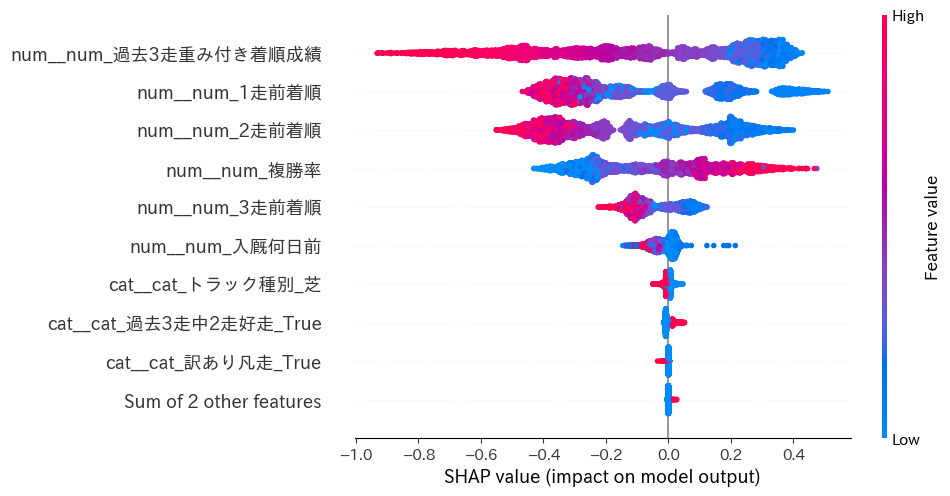

In [ ]:
shap.plots.beeswarm(shap_values)

## SHAP interaction values

Next look at interactions between the features.

The higher the number, the more significant the impact on the model's predictions. For example, if A and B are two features, and the interaction value for A and B is high, then we can say that the model's predictions are significantly impacted by the interaction between A and B.

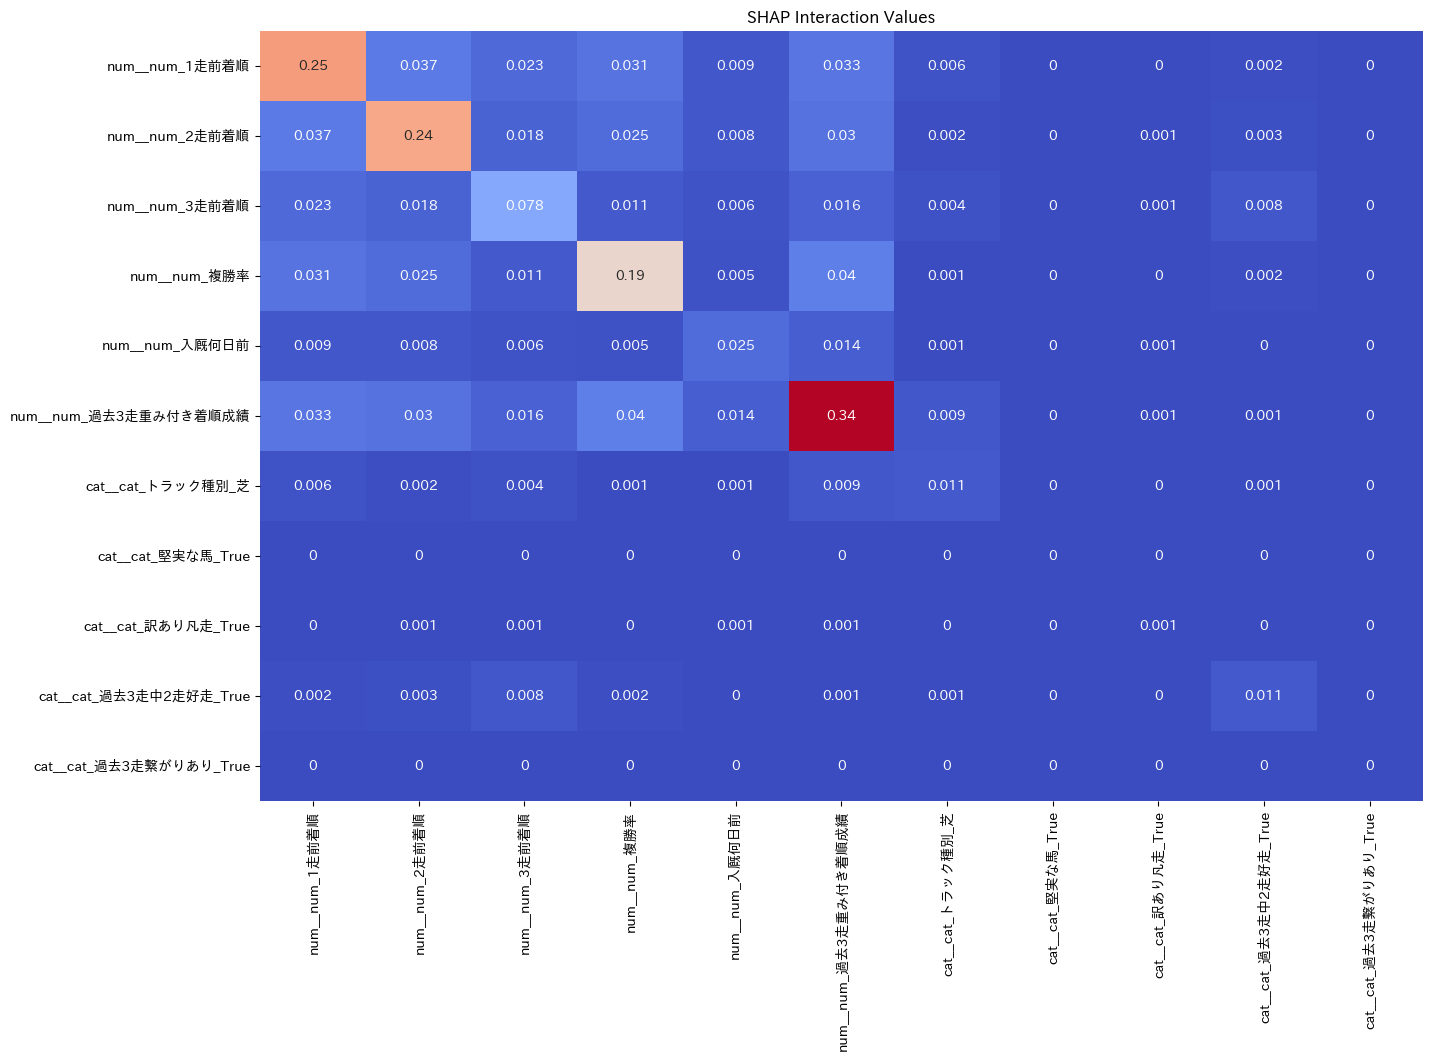

In [ ]:
japanize_matplotlib.japanize()

mean_shap = np.abs(shap_interaction_values).mean(0)

df = pd.DataFrame(
    mean_shap,
    index=preprocessor.get_feature_names_out(),
    columns=preprocessor.get_feature_names_out(),
)

df.where(df.values == np.diagonal(df), df.values * 2, inplace=True)

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.round(decimals=3), cmap="coolwarm", annot=True, cbar=False, ax=ax)
ax.set_title("SHAP Interaction Values")
plt.show()

## Dependence Plot

To view how two features interact with each other in relation to the predicted value, use a dependence plot.

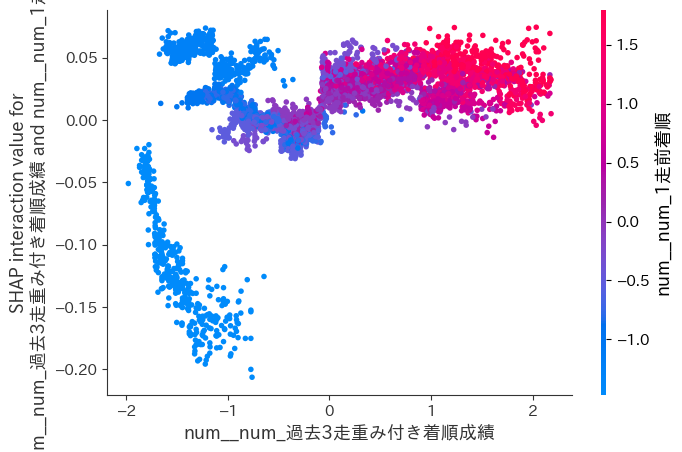

In [ ]:
shap.dependence_plot(
    ind=("num__num_過去3走重み付き着順成績", "num__num_1走前着順"),
    shap_values=shap_interaction_values,
    features=X_test_prep_sample,
    feature_names=preprocessor.get_feature_names_out(),
)

### Waterfall plot

Use this plot to show how the model arrived at the final prediction given the various features. Each row shows the individual feature contribution to the final prediction.

`f(x)` is calculated with this formula (the number is the value of the prediction)

```
f(x) = ln(0.39291951 / (1 - 0.39291951))
```

The numbers in the y axis numbers (X = feature_name) are the test data as-is.

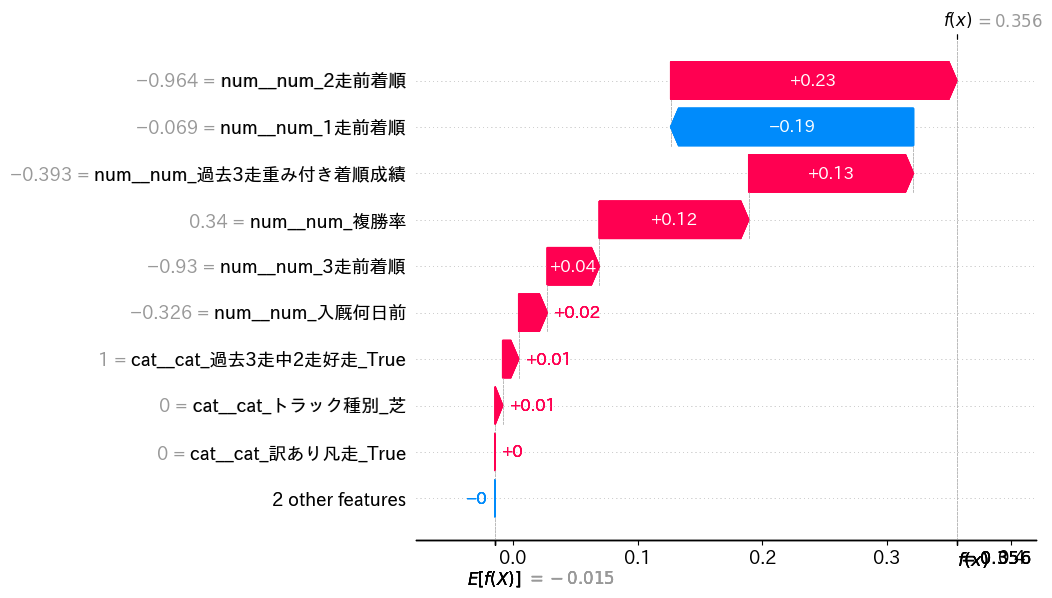

In [ ]:
# ax = shap.plots.waterfall(shap_values[4], show=False)
# fig = ax.get_figure()
# fig.savefig("waterfall.png")
shap.plots.waterfall(shap_values[4])

### Stacked Force Plot

In [ ]:
shap.plots.force(shap_values[0:100])

### Mean SHAP

Shows you which features are most important for a model's predictions.

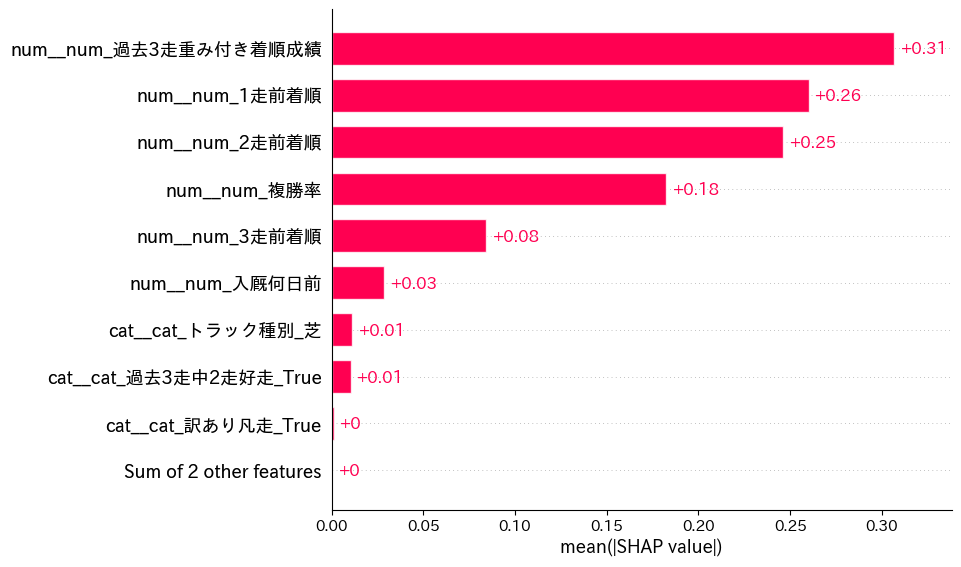

In [ ]:
shap.plots.bar(shap_values)

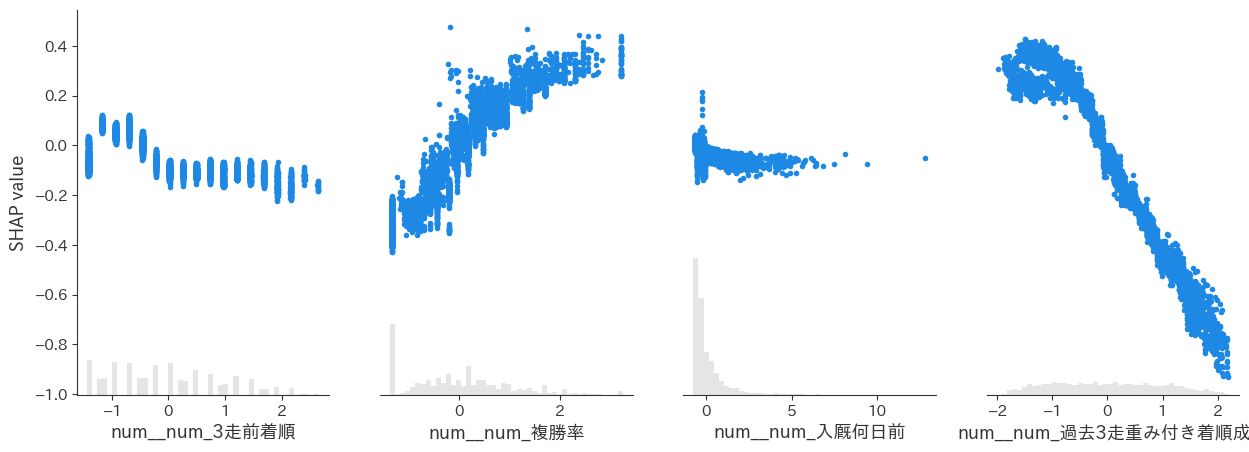

In [ ]:
shap.plots.scatter(shap_values[:, 2:6])